# Compute the separation of variables expansion with `neat.SOVTree`

The separation of variables expansion [-@Major1993] computes impedance kernels as superpositions of exponentials:
\begin{align}
z_{x^{\prime}x}(t) = \sum_{k=0}^{\infty} e^{-\frac{t}{\tau_k}} \, \phi_k(x^{\prime}) \, \phi_k(x)
\end{align}
which can be used to compute PSP responses to current inputs analytically, or even to simulate the neuron model as:
\begin{align}
\dot{y}_k(t) &= -\frac{y_k(t)}{\tau_k} + \int \mathrm{d}x \, \phi_k(x) \, I(x, t, V(x,t)) \hspace{4mm} \forall k \\
V(x,t) &= \sum_k \phi_k(x) \, y_k(t),
\end{align}
with $I(x,t, V(x,t))$ the possibly voltage-dependent input current at location $x$ along the dendrite and at time $t$.

`neat.SOVTree` implements Major's algorithm [-@Major1993] to compute the SOV solution. A `neat.SOVTree` is initialized like any other `neat` tree:

In [1]:
import numpy as np
import matplotlib.pyplot as pl

from neat import SOVTree

# load the tree
sov_tree = SOVTree('morph/N19ttwt.CNG.swc')
# capacitane 1 uF/cm^2 and axial resistance 0.0001 MOhm*cm
sov_tree.set_physiology(1., 0.0001)
# fit the leak conductance to have an equilibrium potential of -75. and a
# uniform membrane time scale of 10 ms
sov_tree.fit_leak_current(-75., 10.)
# set the computational tree
sov_tree.set_comp_tree()



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0-post0.dev0
 Built: Jan 10 2025 14:51:17

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



Then, the exponential time-scales $\tau_k$ are computed as the zeros of the transcendental equation.

In [2]:
# construct transcendental equation
sov_tree.calc_sov_equations(maxspace_freq=100.)

We may then obtain the exponential time-scales $\tau_k$ and associated spatial functions $\phi_k(x_i)$, the latter evaluated at a set of locations $(x_1, ..., x_N)$. In this case, we will only plot the spatial modes, so we define a set of locations that is good for plotting spatial functions defined on the morphology ('xaxis').

In [3]:
# creates and stores (under the name 'xaxis') a set of locations on the morphology good for plotting
sov_tree.make_x_axis()

To asses the importance of a mode for the voltage dynamics at a given set of locations, we use the metric
\begin{align}
\text{Imp}_k = \sqrt{\tau_k \left( \sum_{i=0}^N \sum_{j=0}^N \phi_k(x_i) \, \phi_k(x_j) \right) }
\end{align}
We may then obtain the most important SOV terms at the set of locations stored under 'xaxis':

In [4]:
alphas, phimat = sov_tree.get_sov_matrices('xaxis')

We can also define a cutoff threshold. Modes with relative importance below this threshold ($\text{Imp}_k < \epsilon \, \text{Imp}_0$) are not returned

In [5]:
alphas_, phimat_ = sov_tree.get_important_modes(loc_arg='xaxis', eps=1e-3)
# compare the size of alphas with the size of alphas_
print('Number of SOV terms in alphas =', alphas.shape[0])
print('Number of SOV terms in alphas_ =', alphas_.shape[0])

Number of SOV terms in alphas = 120
Number of SOV terms in alphas_ = 37


Note furthermore that this function returns the reciprocals of the timescales $\alpha_k = \frac{1}{\tau_k}$, in kHz. The time-scales can be obtained in ms as:

In [6]:
print('tau_k (k=0,...36) =\n',1./alphas_)

tau_k (k=0,...36) =
 [10.          1.17930791  0.87175063  0.74621091  0.61592058  0.55352705
  0.51001138  0.46019773  0.33093398  0.22778449  0.18268101  0.1810243
  0.15825737  0.1555517   0.09367747  0.08063473  0.07379258  0.06509325
  0.05731892  0.0533252   0.04952842  0.04547815  0.03806818  0.03576512
  0.02960574  0.0277235   0.02652117  0.02224916  0.02059959  0.02033902
  0.02004149  0.0193636   0.01900246  0.01658901  0.01623951  0.01467919
  0.01362795]


The spatial functions are returned as the second argument of `SOVTree.getSOVMatrics()` or `SOVTree.get_important_modes()`. The first dimension signifies the index of the SOV term and the second dimension the index of the location.

In [7]:
print('`phimat` is evaluated for %d SOV terms and at %d locations, stored under \'xaxis\''%phimat_.shape)

`phimat` is evaluated for 37 SOV terms and at 223 locations, stored under 'xaxis'


Finally, we may plot these spatial functions by unraveling the morphology on a one-dimensional axis.

/Users/wybo/Code/NEAT_public/src/neat/trees/morphtree.py:2767: SyntaxWarning:invalid escape sequence '\m'


TypeError: string indices must be integers, not 'str'

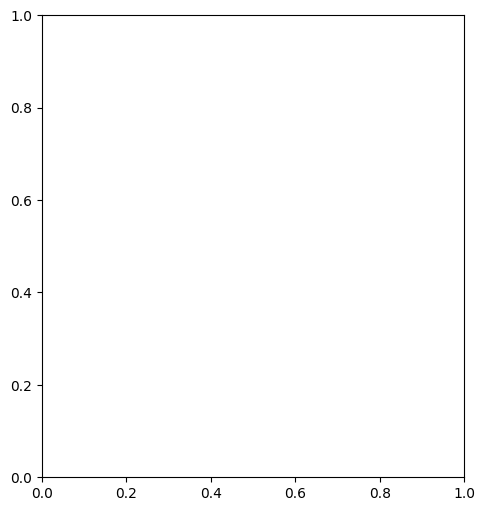

In [8]:
pl.figure(figsize=(12,6))
colours = list(pl.rcParams['axes.prop_cycle'].by_key()['color'])
# plot the morphology
ax0 = pl.subplot(121)
# sov_tree.set_node_colors()
sov_tree.plot_2d_morphology(ax0, cs='node_color', cmap=pl.get_cmap('jet'), plotargs={'lw':3})
# plot the spatial mode functions
ax1 = pl.subplot(122)
for ii, phi in enumerate(phimat_[:10]):
    sov_tree.plot_1d(ax1, phi.real, c=colours[ii%len(colours)],
                    label=r'$\tau_'+'{%d} = %.5f$ ms'%(ii, 1./alphas_[ii].real))
sov_tree.color_x_axis(ax1, cmap=pl.get_cmap('jet'))
ax1.legend(loc='lower center', ncol=3, bbox_to_anchor=(.5,.9))

pl.tight_layout()
pl.show()